# 5. GLMの尤度比検定と検定の非対称性

(ざっくり要約)

* 現状の統計モデリングは試行錯誤主義である．
    * ゆーい差が出ない → 変数変換 → ゆーい差が出た！ (☝՞ਊ ՞)☝
* たまたま得られた観測データ群から推定されたモデルが「真のデータ」になることなんてほぼ無い．
    * つまり，帰無仮説検定は根本的に問題がある．
    * [この本](https://www.amazon.co.jp/伝えるための心理統計-効果量・信頼区間・検定力-大久保街亜/dp/4326250720)の冒頭で大久保先生や岡田先生も同じことを仰っていた**気がする** (うろ覚え)．
* モデルの尤度を比較するための2つの尤度比検定がある (メモ: 対数尤度の差は尤度の比と対応する)．
    1. パラメトリックブートストラップ法．汎用性が高い．
    2. χ二乗値による近似計算．サンプルサイズが十分に大きい場合に有効である．本来100個じゃ足りない．
* AICによるモデル選択は「良い予測をするモデル」の選択である一方，尤度比検定の場合は有意かどうかの判断のみを行い，良さの大小について言及しない．
* p値はサンプル数等に依存するため，p値の小ささと効果の大きさは必ずしも対応しない．

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
d = pd.read_csv('data3a.csv')

## パラメトリックブートストラップ法

In [3]:
# ポワソン分布のランダム変量 (random variates)
d['y_rnd'] = stats.poisson.rvs(d['y'].mean(), size=100)

In [4]:
fit1 = smf.glm('y_rnd ~ 1', data=d, family=sm.families.Poisson()).fit()
fit2 = smf.glm('y_rnd ~ x', data=d, family=sm.families.Poisson()).fit()
fit1.deviance - fit2.deviance

0.66724591478630657

In [5]:
def get_dd(d, i):
    d = d.copy()
    d['y_rnd'] = stats.poisson.rvs(d['y'].mean(), size=len(d))
    fit1 = smf.glm('y_rnd ~ 1', data=d, family=sm.families.Poisson()).fit()
    fit2 = smf.glm('y_rnd ~ x', data=d, family=sm.families.Poisson()).fit()
    return fit1.deviance - fit2.deviance


def pb(d, n_bootstrap):  # parametric bootstrap法
    return [get_dd(d, i) for i in range(n_bootstrap)]


dd12 = pb(d, n_bootstrap=1000)

In [6]:
dd12 = pd.Series(dd12)
dd12.describe()

count    1000.000000
mean        1.017367
std         1.453350
min         0.000014
25%         0.104907
50%         0.443979
75%         1.335505
max        11.664267
dtype: float64

(0, 20)

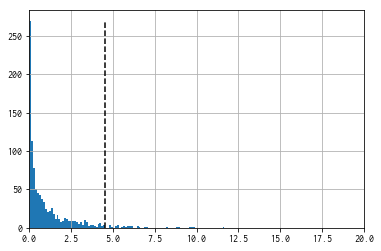

In [7]:
dd12.hist(bins=100)
max_hist_values = np.histogram(dd12, bins=100)[0].max()
plt.vlines(4.5, 0, max_hist_values, linestyles='--')
plt.xlim(0, 20)

In [8]:
sum(dd12 >= 4.5)

34

In [9]:
# 5%有意水準の場合，この数値以下の値は偶然の差とみなされる
dd12.quantile(0.95)

3.9114631763221253

y_rndはxによって予測できないはずであるから，dd12には「予測できない値に対してxを適用したときに減少した逸脱度」になる．したがって，「yをxで予測したときの逸脱度の減少量」がdd12の95%クオンタイル点を越えるということは「予測できない値にxを適用したにしては，逸脱度が減りすぎだよね → yはxで予測できるんじゃない?」となる．

## Χ二乗分布を使った近似計算

In [10]:
fit1 = smf.glm('y ~ 1', data=d, family=sm.families.Poisson()).fit()
fit2 = smf.glm('y ~ x', data=d, family=sm.families.Poisson()).fit()

In [11]:
# Rのanova(fit1, fit2, test = "Chisq") に対応
delta = fit1.deviance - fit2.deviance  # 4.514
ddof = fit1.df_resid - fit2.df_resid  # 1
1 - stats.chi2.cdf(4.514, 1)  # p value

0.033618533016720242

deltaで求めた逸脱度の差は，モデルによって追加されたパラメータの数 (= ddof) を自由度とするカイ二乗分布に近似できる**場合がある**．したがって，自由度ddofに従うカイ二乗累積分布において「1 - deltaに対応した累積確率」を計算ことで，「偶然生じた逸脱度の差にしてはΧ二乗値が大きすぎだよね → この逸脱度の差は偶然では無いレベルで大きいんじゃないか?」となる．